In [1]:
import pprint
import os
from rdflib import Namespace
from cmmn3 import parseModel, convertModel, convertLog, reasonAll, visualize

n3Path = "cmmn3/n3/"
xmlNs = {"cmmn": "http://www.omg.org/spec/CMMN/20151109/MODEL"}
modelNs = Namespace("http://ontario.org/qbp/cap#")

xmlPath = "/Users/wvw/Dropbox/research/projects/Montfort PM/cmmn/cap-all.cmmn"
modelPath = "ttl/cap/model.ttl"
obsFolder = "ttl/cap/obs"
imgPath = "js/diagram.png"

## Convert TTL

### Model

In [2]:
itemObjs = parseModel(xmlPath, xmlNs)
# pprint.pprint(itemObjs)
convertModel(itemObjs, modelNs, modelPath)

### Log

In [3]:
convertLog("csv/log.csv", modelNs, destFolder=obsFolder)

## Check compliance

### Get model

In [4]:
itemObjs = parseModel(xmlPath, xmlNs)

### Reason

In [15]:
out = reasonAll(modelPath, obsFolder, n3Path, itemObjs, printerr=False)
print("errors:", out[0].columns)
print("finals:", out[1].columns)

ttl/cap/obs/obs0.ttl
time: 0.08014716696925461
ttl/cap/obs/obs1.ttl
time: 0.07228425005450845
errors: Index(['case', 'item', 'itemId', 'error', 'type'], dtype='object')
finals: Index(['case', 'item', 'itemId', 'type'], dtype='object')


### Show

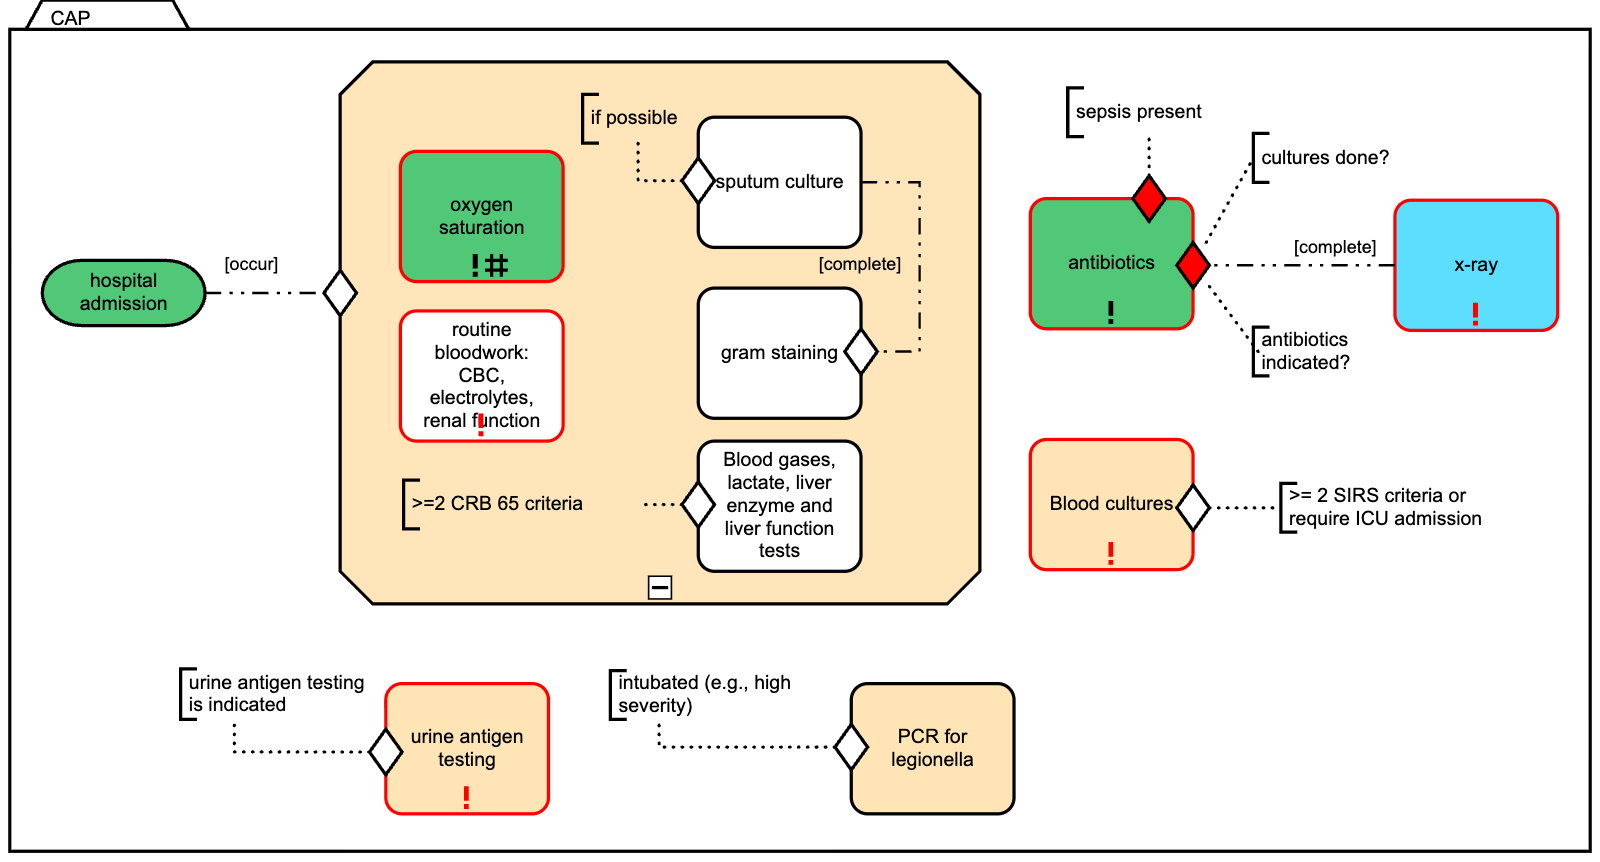

In [16]:
from IPython.display import Image, display

visualize(out, 1, itemObjs, xmlPath, imgPath)
display(Image(filename=imgPath))